# Stylefinder AI - Backend Overview

In [1]:
from IPython.display import IFrame
from milestone_5.embeddings_visualizer import visualize_embeddings
import requests
import json

from src.ai.app import outfit_recommendation_handler

/home/gabriele/Scrivania/PythonProjects/BackEnd-StyleFinderAI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-30 16:31:19,484 - INFO - ✅ Supabase client initialized successfully.
2025-11-30 16:31:19,522 - INFO - ✅ Gemini client initialized successfully.
2025-11-30 16:31:22,554 - INFO - ✅ CLIP model initialized successfully on device: cpu


## Database Schema

Our application uses **Supabase** as the database platform, primarily chosen for its native support of vector embeddings storage (via `pgvector`), which is essential for our AI-powered product recommendation system.

The database consists of five core tables:

- **users**: Stores user authentication data (email, password) and tracks account creation/verification
- **conversations**: Acts as the central hub, linking users to their chat sessions with title and timestamps
- **prompts**: Captures user input messages, each associated with a conversation and optionally linked to images
- **ai_responses**: Stores Gemini's responses with both short summaries and detailed explanations for each conversation
- **product_data**: Contains product information including titles, URLs, brand, category, pricing, and crucially, multipoint embeddings for semantic search

The **outfit_suggestion** junction table connects AI responses to recommended products, enabling the system to track which products Gemini suggests in each interaction. Additionally, **product_colors** stores LAB color values for each product, while **product_material** links products to their materials through a many-to-many relationship via the **materials** table.

In [3]:
IFrame("db_schema.pdf", width="100%", height=800)

## How AI works

## Application Workflow

The application provides AI-powered outfit recommendations through a multi-step process:

1. **User Input**: Users submit a prompt describing an event or occasion for which they need outfit suggestions
2. **Text Generation**: Gemini processes the request and generates a detailed textual description of appropriate outfit combinations
3. **Semantic Matching**: The CLIP model converts both the Gemini-generated text and product images (stored as `img_embeddings` in `product_data`) into a shared vector space
4. **Product Retrieval**: Using Euclidean distance calculations, the system identifies the most semantically similar products from the database, matching the AI's recommendations with actual available items

The t-SNE visualization shows the latent space distribution of our 5,224 product image embeddings, where products naturally cluster by category (tops, shoes, bottom, outerwear, accessories, swimwear, dresses), demonstrating the effectiveness of CLIP's visual-semantic understanding for cross-modal retrieval.

⚙️ Elaborazione vettori...
📊 Matrice pronta: (5224, 512)


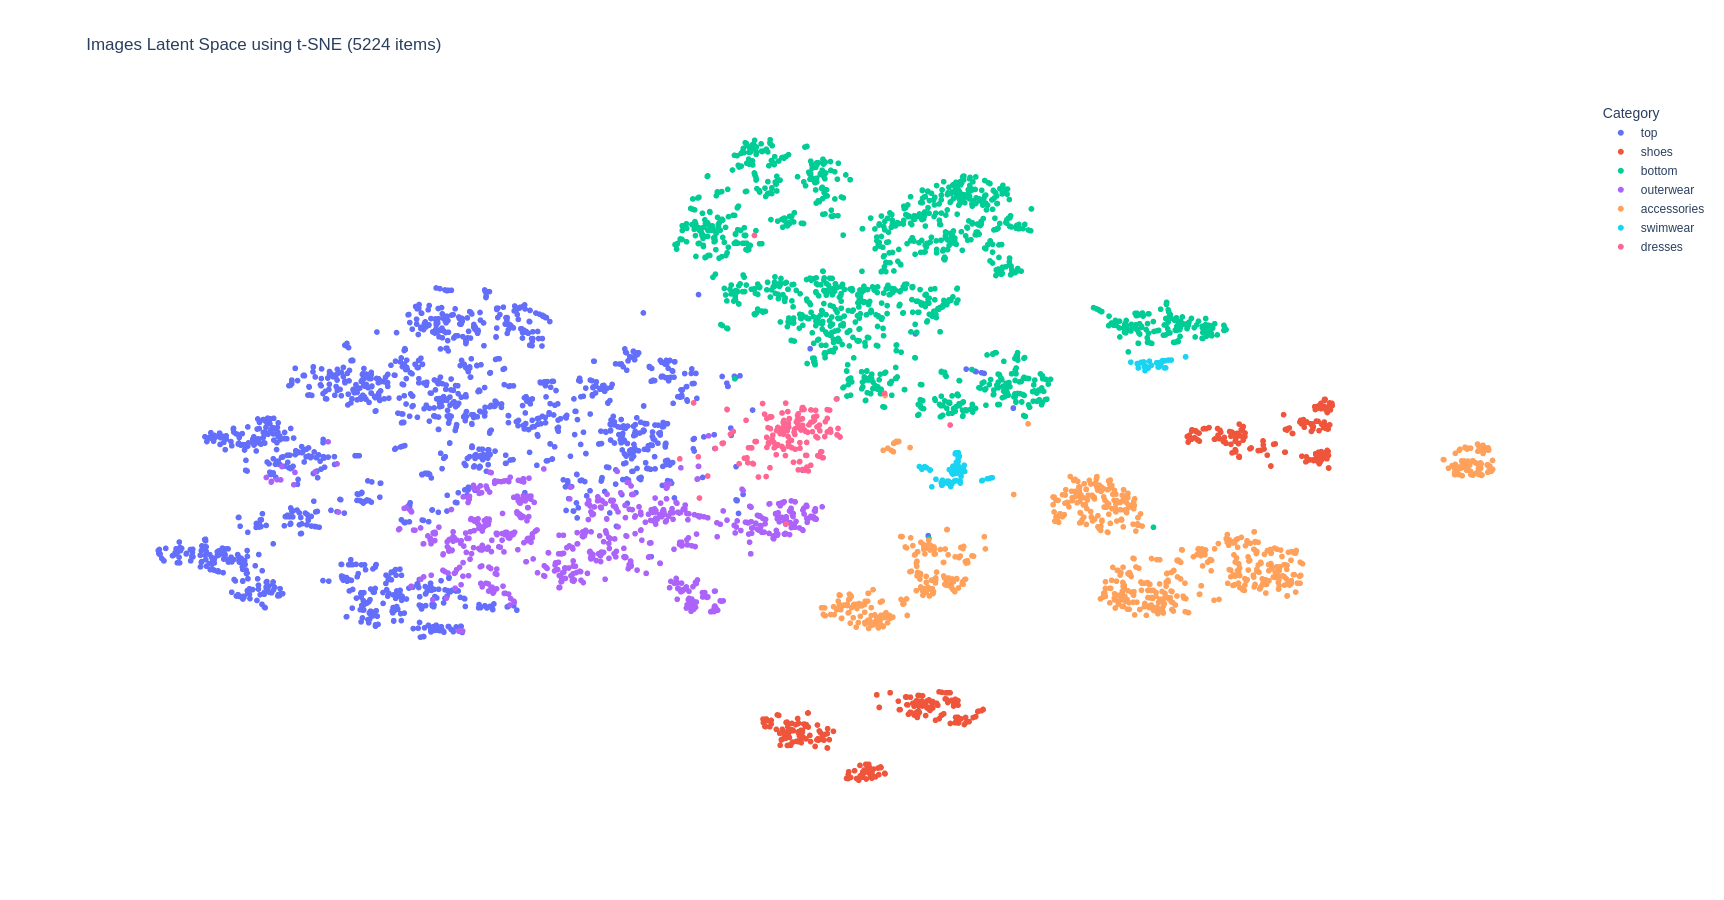

In [3]:
visualize_embeddings()

## Routes Overview

### Main API Routes

The backend exposes several RESTful API endpoints for user management and chat functionality:

| Route | Method | Description |
|-------|--------|-------------|
| `/api/user/` | POST | **Signup** - Register a new user account with email and password |
| `/api/user/login` | POST | **Login** - Authenticate user and create session (returns user data with preferences) |
| `/api/user/logout` | GET | **Logout** - Terminate user session (requires authentication) |
| `/api/messages/send` | POST, PUT | **Send Message** - Submit a user message, optionally with an image. Creates a new conversation if no `conv_id` is provided |
| `/api/conversations` | GET | **Get Conversations** - Retrieve all conversations for the authenticated user |
| `/api/chat` | GET, POST | **Get Messages** - Fetch all messages (user prompts + AI responses) for a specific conversation |
| `/api/user/session` | GET | **Check Session** - Verify if the user session is still valid |
| `/api/user/delete` | DELETE | **Delete Account** - Permanently delete the authenticated user's account |
| `/api/conversations/delete` | DELETE | **Delete Conversation** - Remove a specific conversation |
| `/api/preferences/all` | GET | **Get All Preferences** - Retrieve all user preference settings |
| `/api/conversations/rename` | POST, PUT | **Rename Conversation** - Update the name of a conversation |
| `/api/user/update` | POST | **Update User Credentials** - Modify user email or password |
| `/api/preferences` | POST, PUT | **Update User Preferences** - Save or modify user preference settings |

All authenticated routes use session-based authentication via Flask-Login. The API maintains CORS support for frontend applications running on localhost.

### API Demo

The following cells demonstrate a complete user workflow using `requests.Session()` to maintain authentication state across API calls.

In [34]:
# Configuration
BASE_URL = "http://localhost:8000"
session = requests.Session()

# Test credentials
TEST_EMAIL = "test_demo@example.com"
TEST_PASSWORD = "testpassword123"
TEST_NAME = "Demo User"

print(f"Base URL: {BASE_URL}")
print(f"Test Email: {TEST_EMAIL}")
print(f"Session initialized")

Base URL: http://localhost:8000
Test Email: test_demo@example.com
Session initialized


#### 1. Create Account

Register a new user account. Returns 409 if the email already exists.

In [28]:
# POST /api/user/ - Signup
signup_data = {
    "name": TEST_NAME,
    "email": TEST_EMAIL,
    "password": TEST_PASSWORD
}

try:
    response = session.post(f"{BASE_URL}/api/user/", json=signup_data)
    print(f"POST /api/user/")
    print(f"Status Code: {response.status_code}")
    print(f"Response:\n{json.dumps(response.json(), indent=2)}")
except Exception as e:
    print(f"Error: {e}")

POST /api/user/
Status Code: 201
Response:
{
  "success": true
}


#### 2. Login

Authenticate with email and password. Creates a session cookie for subsequent authenticated requests.

In [29]:
# POST /api/user/login - Login
login_data = {
    "email": TEST_EMAIL,
    "password": TEST_PASSWORD
}

try:
    response = session.post(f"{BASE_URL}/api/user/login", json=login_data)
    print(f"POST /api/user/login")
    print(f"Status Code: {response.status_code}")
    print(f"Response:\n{json.dumps(response.json(), indent=2)}")
    
    # Store user_id for later use
    if response.status_code == 200:
        user_id = response.json()['user']['id']
except Exception as e:
    print(f"Error: {e}")

POST /api/user/login
Status Code: 200
Response:
{
  "success": true,
  "user": {
    "email": "test_demo@example.com",
    "id": 17,
    "name": "Demo User",
    "preferences": {}
  }
}


#### 3. Send Message

Send a message to the AI. If no `conv_id` is provided, a new conversation is created. The AI generates outfit suggestions based on the message.

In [30]:
# POST /api/messages/send - Send a message (creates new conversation)
message_data = {
    "message": "I need a casual outfit for a weekend brunch with friends"
}

try:
    response = session.post(f"{BASE_URL}/api/messages/send", json=message_data)
    print(f"POST /api/messages/send")
    print(f"Status Code: {response.status_code}")
    print(f"Response:\n{json.dumps(response.json(), indent=2)}")
    
    # Store conversation ID for later use
    if response.status_code == 200:
        conv_id = response.json().get('conv_id')
except Exception as e:
    print(f"Error: {e}")

POST /api/messages/send
Status Code: 200
Response:
{
  "content": {
    "explanation": "A versatile ensemble that transitions seamlessly from day to night. The combination of these items ensures you'll look polished and put-together, regardless of the setting.",
    "message": "Outfit Complete: Your personalized selection is ready based on your request.",
    "outfit": [
      {
        "brand": "Mango",
        "id": "97cd5adc-e42b-4133-ade9-f2972b09f47c",
        "image_link": "https://shop.mango.com/assets/rcs/pics/static/T1/fotos/S/17051520_TC_B.jpg?imwidth=2048&imdensity=1&ts=1749544594040",
        "price": 49.99,
        "similarity": 0.399,
        "title": "Denim skirt with frayed hem",
        "url": "https://shop.mango.com/us/en/p/women/skirts/short/denim-skirt-with-frayed-hem_17051520"
      },
      {
        "brand": "H&M",
        "id": "6c3bce43-e087-4d51-9658-d4a177581883",
        "image_link": "https://image.hm.com/assets/hm/61/bc/61bc56fb2c9c8d795b68052fadae14be0ab7

#### 4. Get Conversations

Retrieve all conversations for the authenticated user.

In [31]:
# GET /api/conversations - Get all conversations
try:
    response = session.get(f"{BASE_URL}/api/conversations")
    print(f"GET /api/conversations")
    print(f"Status Code: {response.status_code}")
    print(f"Response:\n{json.dumps(response.json(), indent=2)}")
    
    # Use the first conversation ID if we don't have one from sending
    if response.status_code == 200:
        conversations = response.json().get('conversations', [])
        if conversations and ('conv_id' not in dir() or not conv_id):
            conv_id = conversations[0]['id']
except Exception as e:
    print(f"Error: {e}")

GET /api/conversations
Status Code: 200
Response:
{
  "conversations": [
    {
      "created_at": "Sun, 30 Nov 2025 12:51:39 GMT",
      "id": 39,
      "title": "Casual Weekend Brunch Outfit"
    }
  ],
  "success": true
}


#### 5. Get Messages

Retrieve all messages (user prompts and AI responses) from a specific conversation.

In [32]:
# GET /api/chat - Get messages from a conversation
if 'conv_id' in dir() and conv_id:
    chat_data = {"conv_id": conv_id}
    
    try:
        response = session.get(f"{BASE_URL}/api/chat", json=chat_data)
        print(f"GET /api/chat (conv_id: {conv_id})")
        print(f"Status Code: {response.status_code}")
        print(f"Response:\n{json.dumps(response.json(), indent=2)}")
    except Exception as e:
        print(f"Error: {e}")
else:
    print("No conversation ID available. Please run the 'Send Message' cell first.")

GET /api/chat (conv_id: 39)
Status Code: 200
Response:
[
  {
    "created_at": "Sun, 30 Nov 2025 12:51:39 GMT",
    "image_id": null,
    "message_id": 47,
    "role": "user",
    "text": "I need a casual outfit for a weekend brunch with friends"
  },
  {
    "created_at": "Sun, 30 Nov 2025 12:51:44 GMT",
    "explanation": "A versatile ensemble that transitions seamlessly from day to night. The combination of these items ensures you'll look polished and put-together, regardless of the setting.",
    "message_id": 47,
    "outfits": [
      {
        "brand": "ZARA",
        "id": "4b556be9-f9d8-47cd-8803-c9b4d9d2c874",
        "image_link": "https://static.zara.net/assets/public/3766/6b18/5eb04f73a300/6de0cd49ef94/01277004802-e1/01277004802-e1.jpg?ts=1751368712923&",
        "material": "OUTER SHELLMAIN FABRIC100% cottonSECONDARY FABRIC95% cotton5% elastane",
        "price": 39.9,
        "title": "BILLIE EILISH BRAVADO\u2122 T-SHIRT",
        "url": "https://www.zara.com/us/en/billi

#### 6. Logout

Terminate the user session.

In [33]:
# GET /api/user/logout - Logout
try:
    response = session.get(f"{BASE_URL}/api/user/logout")
    print(f"GET /api/user/logout")
    print(f"Status Code: {response.status_code}")
    print(f"Response:\n{json.dumps(response.json(), indent=2)}")
except Exception as e:
    print(f"Error: {e}")

GET /api/user/logout
Status Code: 200
Response:
{
  "success": true
}


## AI Functional API Demo

In [2]:
outfit = outfit_recommendation_handler("An outfit for a wedding event. No budget limit or other constraints", [], None, None, None)
print(json.dumps(outfit, indent=2))

2025-11-30 16:31:29,603 - INFO - --- Sending request to Gemini for state transition... ---
2025-11-30 16:31:29,608 - INFO - AFC is enabled with max remote calls: 10.
2025-11-30 16:31:30,847 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 200 OK"
2025-11-30 16:31:30,851 - INFO - AFC is enabled with max remote calls: 10.
2025-11-30 16:31:33,407 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 200 OK"
2025-11-30 16:31:33,413 - INFO - LLM is READY_TO_GENERATE. Final Budget: 100000
2025-11-30 16:31:33,414 - INFO - Generating embeddings for 6 items...
2025-11-30 16:31:33,869 - INFO - Searching product candidates in vector DB...


{}


2025-11-30 16:31:34,262 - INFO - HTTP Request: POST https://htxyfhpgxtbqymcypenk.supabase.co/rest/v1/rpc/search_outfits "HTTP/2 200 OK"
2025-11-30 16:31:34,461 - INFO - HTTP Request: POST https://htxyfhpgxtbqymcypenk.supabase.co/rest/v1/rpc/search_outfits "HTTP/2 200 OK"


{}
{}


2025-11-30 16:31:34,738 - INFO - HTTP Request: POST https://htxyfhpgxtbqymcypenk.supabase.co/rest/v1/rpc/search_outfits "HTTP/2 200 OK"
2025-11-30 16:31:34,942 - INFO - HTTP Request: POST https://htxyfhpgxtbqymcypenk.supabase.co/rest/v1/rpc/search_outfits "HTTP/2 200 OK"


{}
{}


2025-11-30 16:31:35,252 - INFO - HTTP Request: POST https://htxyfhpgxtbqymcypenk.supabase.co/rest/v1/rpc/search_outfits "HTTP/2 200 OK"
2025-11-30 16:31:35,455 - INFO - HTTP Request: POST https://htxyfhpgxtbqymcypenk.supabase.co/rest/v1/rpc/search_outfits "HTTP/2 200 OK"


{}


2025-11-30 16:31:35,461 - INFO - Assembling and optimizing outfit with Knapsack...
2025-11-30 16:31:45,758 - INFO - Generating outfit explanation...
2025-11-30 16:31:45,758 - INFO - AFC is enabled with max remote calls: 10.
2025-11-30 16:31:47,948 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent "HTTP/1.1 200 OK"
2025-11-30 16:31:47,951 - INFO - Successfully assembled and explained outfit.


{
  "outfit": [
    {
      "title": "Slim Fit Easy-iron Shirt",
      "url": "https://www2.hm.com/en_us/productpage.1242812006.html",
      "id": "ad930b0e-aec4-4f1a-81a0-12051d369ba9",
      "similarity": 0.3467,
      "image_link": "https://image.hm.com/assets/hm/39/43/39436d0f6e0d97e91dc9f29b2572bc5db3d74277.jpg",
      "price": 19.99
    },
    {
      "title": "Slim-Fit Suit Pants",
      "url": "https://www2.hm.com/en_us/productpage.1256060003.html",
      "id": "26f824e6-981e-4d9f-9b67-ff4f4886a7bc",
      "similarity": 0.3346,
      "image_link": "https://image.hm.com/assets/hm/f1/7b/f17b828643071471549882b419b9feb1cb9dba03.jpg?imwidth=768",
      "price": 59.99
    },
    {
      "title": "Slim-Fit Jacket",
      "url": "https://www2.hm.com/en_us/productpage.1250484003.html",
      "id": "30e17eda-8372-4436-ad15-d08b3fa9b53a",
      "similarity": 0.3403,
      "image_link": "https://image.hm.com/assets/hm/80/69/8069dfe66cb2674da290daf0cd899525df9a2e0d.jpg",
      "price": 84.